In [2]:
import torch
import sys

sys.path.append('..')

import SourceCode

import torch
from SourceCode.utilities import nth_derivative
from SourceCode.EquationClass import MainEquationClass
from SourceCode.DomainClass import TwoDimensionalSimpleDomain
from SourceCode.TrainerForNNEquationSolver import TrainerForNNEquationSolver
from SourceCode.ReportMaker import ReportMaker
from SourceCode.utilities import plot_two_2d_functions
from SourceCode.InitConditionClass import TwoDimInitialCondition
from math import pi

# №1

$$ U_{xx}+U_{yy}+1=0 $$
$$U(-1,y)=0$$
$$U(1,y)=0$$
$$U(x,-1)=0$$
$$U(x,1)=0$$
$$ Analytical\_sol = (\frac{8}{\pi^2})^2\sum_{i=1,3,5..}\sum_{j=1,3,5..}\frac{(-1)^{(i+j)/2-1}}{i*j*(i^2+j^2)}cos(i\frac{\pi}{2}x)cos(j\frac{\pi}{2}y)$$
$$ approximation satisfying init conditions: appr = (1-x^2)(1-y^2)nn\_model(x,y) $$

here is an example how we can explicitly specify approximation satifying boundary conditions so we dont have to pass boundary conditions as arguments

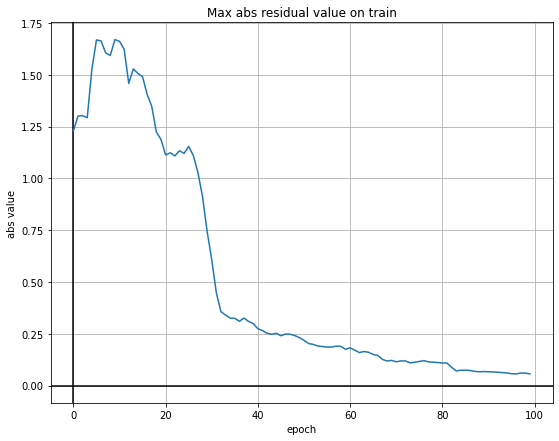

Comparison of approximation and analytical solution:
Train max absolute error |Appr(x)-y(x)|: 0.01955430954694748
Valid max absolute error |Appr(x)-y(x)|: 0.01955430954694748
MAPE on train data: 0.2672505332157016 %
MAPE on validation data: 0.2672505332157016 %
Max abs value of residual on train at last epoch: 0.05597507953643799 


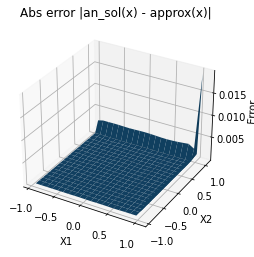

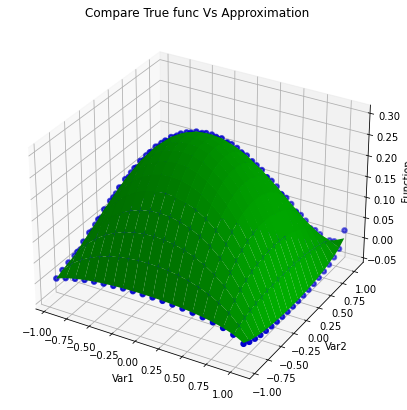

train data
     Input_X1  Input_X2  Analytical_F     ANN_F     Error
0   -0.947368 -0.947368      0.005976  0.005995  0.000019
1   -0.947368 -0.842105      0.014168  0.014135  0.000033
2   -0.947368 -0.736842      0.019931  0.019957  0.000027
3   -0.947368 -0.631579      0.024260  0.024271  0.000011
4   -0.947368 -0.526316      0.027570  0.027550  0.000019
..        ...       ...           ...       ...       ...
395  1.052632  0.631579     -0.024260 -0.026998  0.002738
396  1.052632  0.736842     -0.019931 -0.022702  0.002772
397  1.052632  0.842105     -0.014168 -0.016982  0.002814
398  1.052632  0.947368     -0.005976 -0.008120  0.002145
399  1.052632  1.052632      0.005976  0.025530  0.019554

[400 rows x 5 columns]


In [3]:
x1_points = 20
x1_left = -1
x1_right = 1
x2_points = 20
x2_left = -1
x2_right = 1
    
    
def true_sol(x, y):
    total_sum = 0
    lim = 100
    for i in range(1, lim, 2):
        for j in range(1, lim, 2):
            total_sum += pow(-1, (i + j) // 2 - 1) / (i * j * (i * i + j * j)) * torch.cos(
                i * pi / 2 * x) * torch.cos(j * pi / 2 * y)
    total_sum *= 8*8/(pi*pi*pi*pi)
    return total_sum
    
    
true_solution = true_sol
    
main_domain = TwoDimensionalSimpleDomain(x1_points,
                                            x1_left,
                                            x1_right,
                                            x2_points,
                                            x2_left,
                                            x2_right)
main_eq_residuals = lambda x, y, nn_model: (nth_derivative(nn_model(x, y), x, 2) +
                                            nth_derivative(nn_model(x, y), y, 2) +
                                            torch.tensor(1.0, requires_grad=True))
    
main_eq = MainEquationClass(main_domain, main_eq_residuals)
boundary_satisfying_models = [
    lambda x, y, model: model(x, y) * (1 - x * x) * (1 - y * y)
]
    
n_epochs = 50
nn_ode_solver = TrainerForNNEquationSolver(main_eq,
                                            n_epochs=n_epochs,
                                            boundary_satisfying_models=boundary_satisfying_models,
                                            lr=1)
loss_train, loss_valid, nn_models = nn_ode_solver.fit()
report = ReportMaker(nn_models,
                        loss_train,
                        loss_valid,
                        main_domain,
                        compare_to_functions=plot_two_2d_functions,
                        analytical_solutions=true_solution
                        )
report.print_loss_history()
report.compare_appr_with_analytical()

# № 2

$$ U_{xx}+U_{yy}+1=0 $$
$$U(-1,y)=0$$
$$U(1,y)=0$$
$$U(x,-1)=0$$
$$U(x,1)=0$$
$$ Analytical\_sol = (\frac{8}{\pi^2})^2\sum_{i=1,3,5..}\sum_{j=1,3,5..}\frac{(-1)^{(i+j)/2-1}}{i*j*(i^2+j^2)}cos(i\frac{\pi}{2}x)cos(j\frac{\pi}{2}y)$$

here an example of specifying init conditions if approximation satisfying them is unknown

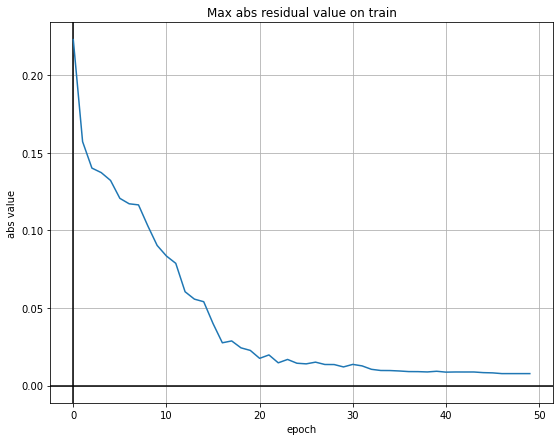

Comparison of approximation and analytical solution:
Train max absolute error |Appr(x)-y(x)|: 0.020362865179777145
Valid max absolute error |Appr(x)-y(x)|: 0.020362865179777145
MAPE on train data: 1.496086549013853 %
MAPE on validation data: 1.496086549013853 %
Max abs value of residual on train at last epoch: 0.007660031318664551 


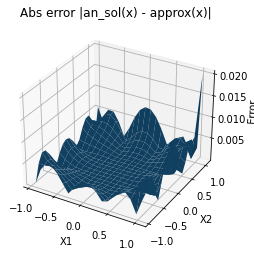

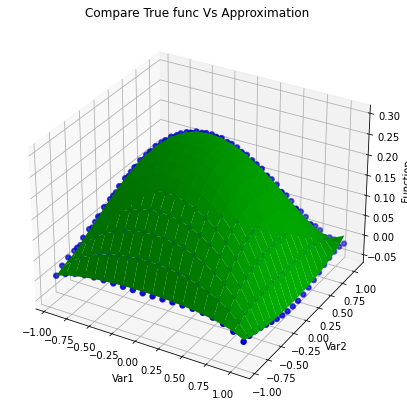

In [4]:
x1_points = 20
x1_left = -1
x1_right = 1
x2_points = 20
x2_left = -1
x2_right = 1
    
    
def true_sol(x, y):
    total_sum = 0
    lim = 100
    for i in range(1, lim, 2):
        for j in range(1, lim, 2):
            total_sum += pow(-1, (i + j) // 2 - 1) / (i * j * (i * i + j * j)) * torch.cos(
                i * pi / 2 * x) * torch.cos(j * pi / 2 * y)
    total_sum *= 8*8/(pi*pi*pi*pi)
    return total_sum
    
    
true_solution = true_sol
    
main_domain = TwoDimensionalSimpleDomain(x1_points,
                                            x1_left,
                                            x1_right,
                                            x2_points,
                                            x2_left,
                                            x2_right)
main_eq_residuals = lambda x, y, nn_model: (nth_derivative(nn_model(x, y), x, 2) +
                                            nth_derivative(nn_model(x, y), y, 2) +
                                            torch.tensor(1.0, requires_grad=True))
    
bc = lambda x, y, model: model(x,y)
bc1 = TwoDimInitialCondition(const_var=-1,
                             non_const_var_left=-1,
                             non_const_var_right=1,
                             non_const_var_size=10,
                             equation=bc,
                             const_var_ind=1)

bc2 = TwoDimInitialCondition(1, -1, 1, 10, bc, 1)
bc3 = TwoDimInitialCondition(-1, -1, 1, 10, bc, 2)
bc4 = TwoDimInitialCondition(1, -1, 1, 10, bc, 2)
boundary_conditions = [bc1, bc2, bc3, bc4]
main_eq = MainEquationClass(main_domain,
                                main_eq_residuals,
                                boundary_conditions=boundary_conditions)
    
n_epochs = 50
nn_ode_solver = TrainerForNNEquationSolver(main_eq,
                                            n_epochs=n_epochs,
                                            lr=1)
loss_train, loss_valid, nn_models = nn_ode_solver.fit()
report = ReportMaker(nn_models,
                        loss_train,
                        loss_valid,
                        main_domain,
                        compare_to_functions=plot_two_2d_functions,
                        analytical_solutions=true_solution
                        )
report.print_loss_history()
report.compare_appr_with_analytical()